In [1]:
import sys
import math

import torch
import numpy as np
import matplotlib.pyplot as plt
import dsdl
import gpytorch
import tqdm


from torcheval.metrics import BinaryAUROC

sys.path.append("..")

from src._97_gpytorch import LogisticGPVI, GPModel, LogitLikelihood, PGLikelihood

%load_ext autoreload
%autoreload 2

In [43]:
data = dsdl.load("cod-rna")

In [44]:
np.random.seed(1)

X, y = data.get_train()
X = X.todense()

X = torch.tensor(X, dtype=torch.float)
Xstd = X.std(dim=0)
Xmean = X.mean(dim=0)
X = (X - Xmean) / Xstd
y = torch.tensor(y, dtype=torch.float)
y[y == -1] = 0


X_test, y_test = data.get_test()
X_test = X_test.todense()
y_test[y_test == -1] = 0

n_test = 2500
id0 = np.random.choice(np.where(y_test == 0)[0], n_test, replace=False)
id1 = np.random.choice(np.where(y_test == 1)[0], n_test, replace=False)

X_test = np.concatenate((X_test[id0, :], X_test[id1, :]), axis=0)
y_test = np.concatenate((y_test[id0], y_test[id1]), axis=0)

X_test = torch.tensor(X_test, dtype=torch.float)
X_test = (X_test - Xmean) / Xstd
y_test = torch.tensor(y_test, dtype=torch.float)

In [64]:
f0 = LogisticGPVI(y, X, n_inducing=20, n_iter=12, use_loader=True, verbose=False)
f0.fit()
f0.runtime

27.2462739944458

In [65]:
f1 = LogisticGPVI(y, X, likelihood=PGLikelihood(), n_inducing=20, n_iter=12, use_loader=True, verbose=False)
f1.fit()
f1.runtime

30.906986474990845

In [66]:
y_pred = f0.predict(X_test)

auc = BinaryAUROC()
auc.update(y_test, y_pred)
print(auc.compute())

tensor(0.9157, dtype=torch.float64)


In [67]:
y_pred = f1.predict(X_test)

auc = BinaryAUROC()
auc.update(y_test, y_pred)
print(auc.compute())

tensor(0.8855, dtype=torch.float64)


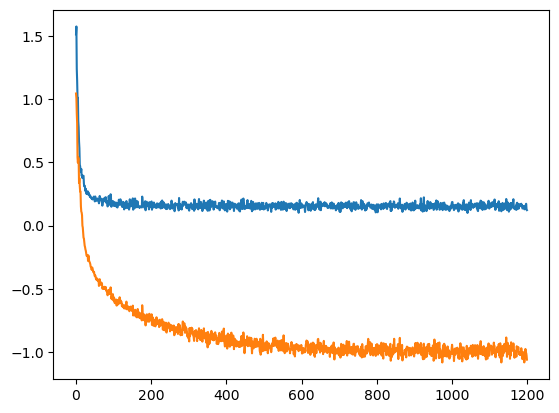

In [68]:
plt.plot(f0.loss)
plt.plot(f1.loss)

In [69]:
# means = f.model(X_test).mean
lower, upper = f0.credible_intervals(X_test)
print( (upper - lower).mean() )

lower, upper = f1.credible_intervals(X_test)
print( (upper - lower).mean() )

tensor(1.4100)
tensor(0.1019)
